In [7]:
import torch
import torchvision
import torch.utils.data as Data
import torch.optim as optim
import random
import numpy as np

from torch import nn
from matplotlib import pyplot as plt
from typing import Tuple

### 回归任务
#### 手动生成的数据集
+ 生成单个数据集。
+ 数据集的大小为10000且训练集大小为7000，测试集大小为3000。
+ 数据集的样本特征维度p为500，且服从如下的高维线性函数: $y = 0.028 + \sum_{i=1}^p0.0056x_i$

In [8]:
torch.random.manual_seed(1)

p = 500
x_train = torch.randn((7000, p))
y_train = 0.028 + 0.0056 * torch.sum(x_train, dim=1)

x_test = torch.randn((3000, p))
y_test = 0.028 + 0.0056 * torch.sum(x_test, dim=1)

print('train:', x_train.shape, y_train.shape)
print('test :', x_test.shape, y_test.shape)

# 构造数据集
train_set = Data.TensorDataset(x_train, y_train)
test_set = Data.TensorDataset(x_test, y_test)

train: torch.Size([7000, 500]) torch.Size([7000])
test : torch.Size([3000, 500]) torch.Size([3000])


#### 手动实现前馈神经网络
分析实验结果并绘制训练集和测试集的loss曲线

In [22]:
def data_iter(x: torch.Tensor, y: torch.Tensor, batch_size: int=8,
              seed=1, shuffle=True):
    """ 数据集生成器 """

    num_samples = x.shape[0]
    indices = list(range(num_samples))
    if shuffle:
        random.seed(seed)
        random.shuffle(indices)

    # 构造小批次数据集
    for i in range(0, num_samples, batch_size):

        # 选取的该批次内的行索引
        j = torch.tensor(indices[i: min(i+batch_size, num_samples)])

        yield x.index_select(dim=0, index=j), y.index_select(0, j)


def sgd(lr, *params):
    """
    优化器-梯度下降
    :param lr:          学习率
    :param params:      参数列表
    :return:
    """
    for param in params:
        # 注意这里更改param时用的param.data
        param.data -= lr * param.grad

def mse(y_hat: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    均方误差损失函数(MSE)
    :param y_hat:   预测值
    :param y_true:  真实值
    :return:
    """
    # train_loss 很低, 但 test_loss 不降, 原因是 y_hat 与 y_true 的形状不一致!!!!
    y_hat = y_hat.view(y_true.size())
    return torch.mean(torch.square(y_hat - y_true))


def tanh(x: torch.Tensor):
    """
    双曲正切
    :param x:
    :return:
    """
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))


def leak_relu(x: torch.Tensor, gamma=0.2):
    """
    带泄露修正线性单元
    :param x:
    :param gamma:
    :return:
    """
    x = torch.where(torch.tensor(x>=0), x, x * gamma)
    return x

def relu(x: torch.Tensor):
    """
    线性单元
    :param x:
    :param gamma:
    :return:
    """
    x = torch.where(torch.tensor(x>=0), x, torch.zeros(x.size()))
    return x

def neural_net(x: torch.Tensor, *params):
    """
    前馈神经网络
    :param x:       特征
    :param params:  模型参数
    :return:
    """
    w1, b1, w2, b2 = params
    # hidden = tanh(torch.mm(x, w1) + b1)
    # hidden = leak_relu(torch.mm(x, w1) + b1)
    hidden = relu(torch.matmul(x, w1) + b1)
    return torch.matmul(hidden, w2) + b2


def evaluate_loss(data_iter, net, loss_fn, *params):
    """
    返回测试集的loss
    :return:
    """
    test_l_sum, n = 0.0, 0
    for x, y_true in data_iter:

        y_hat = net(x, *params)
        y_hat = y_hat.view(y_true.size())

        test_l_sum += loss_fn(y_hat, y_true)
        n += 1

    return test_l_sum / n


# 参数配置
num_inputs = x_train.shape[1]
num_hiddens = 256
num_outputs = 1

batch_size = 256
num_epochs = 50
lr = 0.1
net = neural_net
loss = mse

# 模型训练 w = [w_0, ..., w_n]
w1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)),
                  dtype=torch.float32)
b1 = torch.zeros(num_hiddens, dtype=torch.float32)
w2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)),
                  dtype=torch.float32)
b2 = torch.zeros(num_outputs, dtype=torch.float32)

params = (w1, b1, w2, b2)
for param in params:
    param.requires_grad_(requires_grad=True)

train_loss = []
test_loss = []
for epoch in range(num_epochs):

    # 读取数据集
    iter_train = data_iter(x_train, y_train, batch_size=batch_size)
    iter_test = data_iter(x_test, y_test, batch_size=batch_size)

    # 一批次的训练数据
    train_l_sum, n = 0.0, 0
    for X, y_true in iter_train:

        # 模型预测值
        y_hat = net(X, *params)

        # 损失值
        # (batch_size, 1) => (batch_size, )
        l = loss(y_hat, y_true)

        # 反向传播
        l.backward()

        # 随机梯度下降
        sgd(lr, *params)

        # 梯度置零
        for param in params:
            param.grad.data.zero_()

        train_l_sum += l
        n += 1

    train_l = train_l_sum / n
    test_l = evaluate_loss(iter_test, net, loss, *params)

    train_loss.append(train_l.item())
    test_loss.append(test_l.item())
    print('epoch %d, train_loss %f, test_loss % f' % (epoch, train_l, test_l))


/tmp/ipykernel_4261/3414944646.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.where(torch.tensor(x>=0), x, torch.zeros(x.size()))


epoch 0, train_loss 0.015222, test_loss  0.013972
epoch 1, train_loss 0.012867, test_loss  0.011811
epoch 2, train_loss 0.010321, test_loss  0.009308
epoch 3, train_loss 0.007515, test_loss  0.006703
epoch 4, train_loss 0.004932, test_loss  0.004521
epoch 5, train_loss 0.003063, test_loss  0.003057
epoch 6, train_loss 0.001962, test_loss  0.002209
epoch 7, train_loss 0.001381, test_loss  0.001742
epoch 8, train_loss 0.001074, test_loss  0.001478
epoch 9, train_loss 0.000899, test_loss  0.001321
epoch 10, train_loss 0.000789, test_loss  0.001222
epoch 11, train_loss 0.000714, test_loss  0.001155
epoch 12, train_loss 0.000658, test_loss  0.001108
epoch 13, train_loss 0.000613, test_loss  0.001072
epoch 14, train_loss 0.000576, test_loss  0.001044
epoch 15, train_loss 0.000544, test_loss  0.001021
epoch 16, train_loss 0.000515, test_loss  0.001002
epoch 17, train_loss 0.000490, test_loss  0.000985
epoch 18, train_loss 0.000467, test_loss  0.000970
epoch 19, train_loss 0.000445, test_loss 

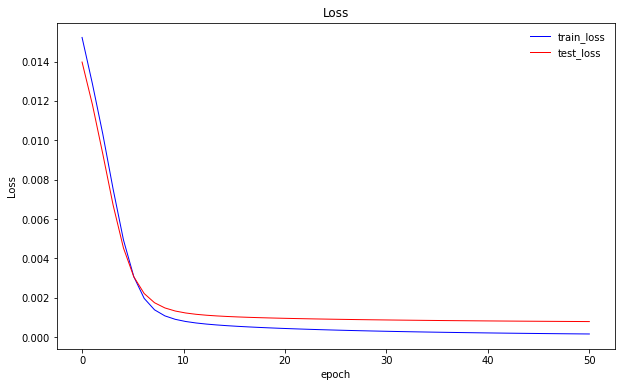

In [23]:
def plot_loss(train_loss_list, test_loss_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    plt.show()

plot_loss(train_loss, test_loss)

#### torch.nn实现前馈神经网络
分析实验结果并绘制训练集和测试集的loss曲线

In [46]:
def train_epoch(data_loader: Data.DataLoader, net: nn.Module,
                loss_func, optimizer: torch.optim.Optimizer,
                device='cpu'):
    """
    训练迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param optimizer:   优化器
    :param device:      设备
    :return:    loss, acc
    """
    net.train()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss、正确样本数、总样本数
    total_loss = 0

    for batch_num, (x, y_true) in enumerate(data_loader):

        # 将数据放入指定的设备
        x = x.to(device).float()

        y_hat: torch.Tensor = net(x)
        y_hat: torch.Tensor = y_hat.view(-1)

        y_true = y_true.to(device).float()
        y_true: torch.Tensor = y_true.view(-1)

        # 计算损失
        loss = loss_func(y_hat, y_true)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss = total_loss / train_batch_num

    return loss


def test_epoch(data_loader: Data.DataLoader,
               net: nn.Module, loss_func, device='cpu'):
    """
    测试函数迭代一次
    :param data_loader: 生成器 (x, y)
    :param net:         模型
    :param loss_func:   损失函数
    :param device:      设备
    :return:    loss, acc
    """
    net.eval()
    train_batch_num = len(data_loader)

    # 一次迭代中的 Loss
    total_loss = 0

    with torch.no_grad():

        for batch_num, (x, y_true) in enumerate(data_loader):

            # 将数据放入指定的设备
            x = x.to(device).float()

            y_hat: torch.Tensor = net(x)
            y_hat: torch.Tensor = y_hat.view(-1)

            y_true = y_true.to(device).float()
            y_true: torch.Tensor = y_true.view(-1)

            # 计算损失
            loss = loss_func(y_hat, y_true)

            total_loss += loss.item()

    loss = total_loss / train_batch_num
    return loss


def plot_loss(train_loss_list, test_loss_list, info=''):
    """
    绘制 训练集和测试集正确率、损失值 的图形
    """
    x = np.linspace(0, len(train_loss_list), len(train_loss_list))
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(10, 6)
    if info:
        info = info + ' '

    ax1.plot(x, train_loss_list, 'b-', label="train_loss", lw=1)
    ax1.plot(x, test_loss_list, 'r-', label="test_loss", lw=1)
    ax1.set_title(info + 'Loss')
    ax1.legend(loc='best', frameon=False)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("Loss")

    plt.show()

class TorchNeuron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 activation=nn.ReLU, num_layers=1, drop_out_rate=0):
        super(TorchNeuron, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.activation = activation
        self.drop_out_rate = drop_out_rate

        self.linear = nn.Sequential(*self.create_linear_layers())

        for param in self.linear.parameters():
            nn.init.normal_(param, std=0.01)

    def create_linear_layers(self) -> Tuple[nn.Module]:
        """
        创建层
        :return:
        """
        modules = [
            nn.Linear(self.input_size, self.hidden_size),
            self.activation(),
            nn.Dropout(self.drop_out_rate),
        ]
        for i in range(self.num_layers - 1):
            modules.append(nn.Linear(self.hidden_size, self.hidden_size))
            modules.append(self.activation())
            modules.append(nn.Dropout(self.drop_out_rate))
        modules.append(nn.Linear(self.hidden_size, self.output_size))
        return tuple(modules)

    def forward(self, x):
        return self.linear(x)

TorchNeuron(
  (linear): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)
epoch 1, train_loss 0.015454, test_loss 0.014022
epoch 2, train_loss 0.013093, test_loss 0.012169
epoch 3, train_loss 0.010715, test_loss 0.009805
epoch 4, train_loss 0.007964, test_loss 0.007217
epoch 5, train_loss 0.005353, test_loss 0.004954
epoch 6, train_loss 0.003373, test_loss 0.003374
epoch 7, train_loss 0.002139, test_loss 0.002401
epoch 8, train_loss 0.001486, test_loss 0.001857
epoch 9, train_loss 0.001131, test_loss 0.001536
epoch 10, train_loss 0.000938, test_loss 0.001365
epoch 11, train_loss 0.000811, test_loss 0.001266
epoch 12, train_loss 0.000729, test_loss 0.001176
epoch 13, train_loss 0.000670, test_loss 0.001116
epoch 14, train_loss 0.000620, test_loss 0.001076
epoch 15, train_loss 0.000583, test_loss 0.001053
epoch 16, train_loss 0.000553, test_loss 

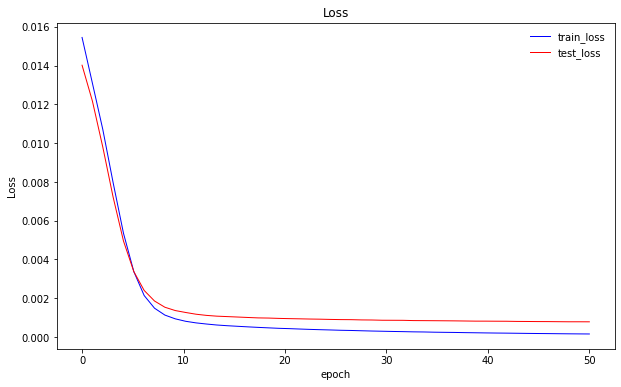

In [47]:
# 参数配置
device = 'cpu'
input_size = x_train.shape[1]
hidden_size = 256
output_size = 1

batch_size = 256
num_epochs = 50
lr = 0.1

net = TorchNeuron(input_size, hidden_size, output_size)
print(net)
loss_func = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    train_loss = train_epoch(data_loader=train_data_loader, net=net,
                                        loss_func=loss_func, optimizer=optimizer, device=device)
    test_loss = test_epoch(data_loader=test_data_loader, net=net,
                                     loss_func=loss_func, device=device)

    print('epoch %d, train_loss %f, test_loss %f'
          % (epoch+1, train_loss, test_loss))

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

plot_loss(train_loss_list, test_loss_list)


####  10折交叉验证评估实验结果
要求除了最终结果外还需以表格的形式展示每折的实验结果

In [48]:
import torch
from sklearn.model_selection import KFold


def train(train_data_loader, test_data_loader):

    net = TorchNeuron(input_size, hidden_size, output_size, drop_out_rate=0.3)
    print(net)
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=0.0)

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(data_loader=train_data_loader, net=net,
                                            loss_func=loss_func, optimizer=optimizer, device=device)
        test_loss = test_epoch(data_loader=test_data_loader, net=net,
                                         loss_func=loss_func, device=device)

        print('epoch %d, train_loss %f, test_loss %f'
              % (epoch+1, train_loss, test_loss))

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    return train_loss_list, test_loss_list

# 参数配置
device = 'cpu'
input_size = x_train.shape[1]
hidden_size = 128
output_size = 1

batch_size = 256
num_epochs = 50
lr = 0.1

X = torch.cat((x_train, x_test))
y = torch.cat((y_train, y_test))

indices = np.arange(0, X.shape[0])
kf = KFold(n_splits=10)

kf_train_loss, kf_test_loss = [], []
for train_index, test_index in kf.split(indices):
    train_index = torch.LongTensor(train_index)
    test_index = torch.LongTensor(test_index)

    train_x = torch.index_select(X, dim=0, index=train_index)
    train_y = torch.index_select(y, dim=0, index=train_index)
    test_x = torch.index_select(X, dim=0, index=test_index)
    test_y = torch.index_select(y, dim=0, index=test_index)

    train_set = Data.TensorDataset(train_x, train_y)
    test_set = Data.TensorDataset(test_x, test_y)

    train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # 训练
    train_loss_list, test_loss_list = train(train_data_loader, test_data_loader)
    kf_train_loss.append(train_loss_list)
    kf_test_loss.append(test_loss_list)

TorchNeuron(
  (linear): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)
epoch 1, train_loss 0.015675, test_loss 0.014335
epoch 2, train_loss 0.014316, test_loss 0.013209
epoch 3, train_loss 0.012602, test_loss 0.010761
epoch 4, train_loss 0.010252, test_loss 0.008072
epoch 5, train_loss 0.007547, test_loss 0.005443
epoch 6, train_loss 0.005385, test_loss 0.003459
epoch 7, train_loss 0.003865, test_loss 0.002333
epoch 8, train_loss 0.003150, test_loss 0.001743
epoch 9, train_loss 0.002705, test_loss 0.001402
epoch 10, train_loss 0.002458, test_loss 0.001206
epoch 11, train_loss 0.002329, test_loss 0.001098
epoch 12, train_loss 0.002031, test_loss 0.000943
epoch 13, train_loss 0.002061, test_loss 0.000886
epoch 14, train_loss 0.001859, test_loss 0.000842
epoch 15, train_loss 0.001799, test_loss 0.000769
epoch 16, train_loss 0.001760, test_los

In [49]:
kf_train_loss_np = np.array(kf_train_loss)
kf_test_loss_np = np.array(kf_test_loss)

print(kf_test_loss_np.min(axis=1))
print(kf_test_loss_np.mean(axis=1))


[0.00028868 0.00031434 0.00031275 0.00030661 0.0003032  0.0003139
 0.0003213  0.00025909 0.00034103 0.00032338]
[0.00163858 0.00184026 0.00177395 0.00171711 0.00174201 0.00167926
 0.00180045 0.00147343 0.00179616 0.00171343]
